In [1]:
import os
import torch
import torchvision
from tqdm.notebook import tqdm 
from sklearn import metrics
import numpy as np 

from dataset.nih_xnet_dataset_feb3 import get_datasets
from abnormality_mask_attention_8432.models.model10 import DesnseNet121

from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

torch.manual_seed(41)

# Dataset and Dataloader 

In [2]:
import json
from easydict import EasyDict as edict

config = None
with open('./config/example.json') as f:
    config = edict(json.load(f))

In [3]:
dataset_train, dataset_test, _ = get_datasets()

# Model Define

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DesnseNet121(num_classes=15)
model = model.to(device)
'''
with torch.no_grad():
    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))
'''

"\nwith torch.no_grad():\n    class_preds, class_hms = model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 15, 224, 224).to('cuda'))\n"

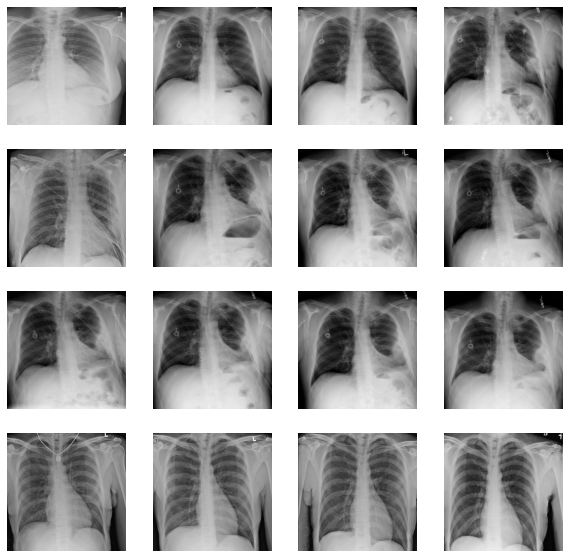

In [5]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,10))
dataiter = iter(dataset_train)

for i in range(16):
    img, _, _, _ = next(dataiter)
    img = torch.tensor(config.pixel_std).view(3, 1, 1) * img + torch.tensor(config.pixel_mean).view(3, 1, 1)
    plt.subplot(4,4,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [6]:
print(model)

DesnseNet121(
  (backbone): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

# Train-Test Functions

In [7]:
@torch.no_grad()
def test():
    model.eval()
    predlist = [[] for i in range(num_diseases)]
    truelist = [[] for i in range(num_diseases)]
    loss_list = []

    for images, abnorm_masks, lung_mask, class_label_gts in testloader:
        images = images.to(device)
        lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        class_label_gts = class_label_gts.to(device)
        
        # class_label_preds, _ = model(images, lung_mask)
        # class_label_preds, _ = model(images)
        class_label_preds, _ = model(images, abnorm_masks, lung_mask)
        loss = loss_function(class_label_preds, class_label_gts)
        loss_list .append(loss.item())
        
        for i in range(num_diseases):
            pred = torch.sigmoid(class_label_preds[:,i]).cpu().detach().numpy()
            predlist[i] = np.append(predlist[i], pred)
            truelist[i] = np.append(truelist[i], class_label_gts[:,i].cpu().detach().numpy())
            
    predlist = np.array(predlist)
    truelist = np.array(truelist)
    loss_list = np.array(loss_list)
    loss_list = loss_list.mean()

    auclist = []
    acclist = []

    for i in range(num_diseases):
        y_pred = predlist[i]
        y_true = truelist[i]
                    
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label = 1)
        auc = metrics.auc(fpr, tpr)
        auclist.append(auc)
        acc = metrics.accuracy_score(y_true,y_pred>0.5)
        acclist.append(acc)
    auc_mean = np.array(auclist).mean()
    acc_mean = np.array(acclist).mean()
            
    model.train()


    print("Auc:",auclist,"  auc mean: ", auc_mean)
    print("Loss mean", loss_list)
    return auclist, auc_mean, acc_mean, loss_list.sum()

In [8]:

def train(global_step, test_metrices, tb_writer):
    model.train()

    acc_mean_train = 0
    acc_list_train = []
    loss_list_train = []
    acc_mean_test = test_metrices['acc_mean_test']
    auc_mean_test = test_metrices['auc_mean_test']
    compare_val_score = test_metrices['best_auc']

    pbar = tqdm(trainloader)
    for images, abnorm_masks, lung_mask, class_label_gts in pbar:
        images = images.to(device)
        lung_mask = lung_mask.to(device)
        abnorm_masks = abnorm_masks.to(device)
        class_label_gts = class_label_gts.to(device)

        model.zero_grad()
        # class_label_preds, _ = model(images, lung_mask)
        # class_label_preds, _ = model(images)
        class_label_preds, _ = model(images, abnorm_masks, lung_mask)
        loss = loss_function(class_label_preds, class_label_gts)
        loss.backward()
        optimizer.step()
        loss_list_train.append(loss.item())

        if global_step%log_step == 0:
            for name, weight in model.named_parameters():
                if weight.grad is not None:
                    tb_writer.add_histogram(name,weight, global_step//log_step)
                    tb_writer.add_histogram(f'{name}.grad', weight.grad, global_step//log_step) 

        if global_step % pbar_step == 0:
            for i in range(num_diseases):
                acc_train = metrics.accuracy_score(class_label_gts[:,i].detach().cpu().numpy(), class_label_preds[:,i].detach().cpu().numpy()>0.5)
                acc_list_train.append(acc_train)

            loss_list_train = np.array(loss_list_train)
            train_loss = loss_list_train.mean()
            acc_list_train = np.array(acc_list_train)
            acc_mean_train = acc_list_train.mean()
            acc_list_train = []
            loss_list_train = []
            lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss': train_loss, 'tacc':acc_mean_train,'vacc':acc_mean_test,'mauc':compare_val_score,'step_auc':auc_mean_test,'epoch':epoch, 'lr':lr})

            tb_writer.add_scalar('Loss/Train', train_loss, global_step//pbar_step)
            tb_writer.add_scalar('Accuracy/Train', acc_mean_train, global_step//pbar_step)
            tb_writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], global_step//pbar_step)


        if global_step % log_step == 0:
            auc_list, auc_mean_test, acc_mean_test, loss_test = test()
            test_metrices['auc_mean_test'] = auc_mean_test
            test_metrices['acc_mean_test'] = acc_mean_test
            
            checkpoint = {
                    'epoch' : epoch,
                    'global_step' : global_step,
                    'model' : model,
                    'optimizer' : optimizer,
                    'test_metrices' : test_metrices
                }
            torch.save(checkpoint, 'last.ckpt')
            
            tb_writer.add_scalar('Loss/Valid', loss_test, global_step//log_step)
            tb_writer.add_scalar('Accuracy/Valid', acc_mean_test, global_step//log_step)
            tb_writer.add_scalar('AUC/Valid', auc_mean_test, global_step//log_step)

            lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss-test': loss_test,'tacc':acc_mean_train,'vacc':acc_mean_test,'mauc':compare_val_score,'step_auc':auc_mean_test,'epoch':epoch, 'lr':lr})

            if auc_mean_test > compare_val_score:
                test_metrices['best_auc'] = auc_mean_test
                checkpoint = {
                    'epoch' : epoch,
                    'global_step' : global_step,
                    'model' : model,
                    'optimizer' : optimizer,
                    'test_metrices' : test_metrices
                }
                torch.save(checkpoint, 'best.ckpt')
                compare_val_score = auc_mean_test
             
        global_step += 1

    return global_step, test_metrices

# Training Parameters

In [9]:
batch_size = 16
epochs = 17
num_diseases = 14
resume = False
log_step = 4904
pbar_step = 1000

In [10]:
trainloader = torch.utils.data.DataLoader(
                    dataset_train, batch_size=batch_size,
                    shuffle=True, drop_last=True, num_workers=4)

# indices = list(range(500))
# tr_10k = torch.utils.data.Subset(dataset_test, indices)
testloader = torch.utils.data.DataLoader(
                    dataset_test, batch_size=batch_size,
                    drop_last = True, num_workers=4)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay =  0.0001)
loss_function = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

# Training Phase

In [12]:
if resume and os.path.exists('last.ckpt'): 
    checkpoint_dict = torch.load("last.ckpt")
    epoch = checkpoint_dict['epoch']
    model = checkpoint_dict['model']
    optimizer = checkpoint_dict['optimizer']
    global_step = checkpoint_dict['global_step'] + 1
    test_metrices = checkpoint_dict['test_metrices']
    model.eval()
else:
    epoch = 1
    global_step = 1
    test_metrices = {
        'acc_mean_test' : 0,
        'auc_mean_test' : 0,
        'best_auc' : 0
    }
    
print(test_metrices['best_auc'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

0


In [13]:
writer = SummaryWriter(log_dir='./runs/model9exp1')
images, _, _, labels = next(iter(trainloader))
image_grid = torchvision.utils.make_grid(images)
writer.add_image("images",image_grid)
# writer.add_graph(model, images.to(device))

while epoch <= epochs:
    global_step, test_metrices = train(global_step, test_metrices, writer)
    if epoch % 5 == 0:
        scheduler.step()
    epoch = epoch + 1
        
writer.close()

  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.7925301518965764, 0.8719078367954324, 0.8649059477415353, 0.6843629663965816, 0.8402315711987034, 0.7297694728589286, 0.7387531808859874, 0.8590553021681664, 0.7983477722013825, 0.9036710239651417, 0.8473155886627908, 0.7813809082483782, 0.7684844054290961, 0.8473050690238445]   auc mean:  0.809144371248039
Loss mean 0.18144616418213885


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8097297589609562, 0.8942784256559765, 0.8682063403226752, 0.6784264515641031, 0.8449848540156216, 0.7459310582022322, 0.7354601879597488, 0.8737975212489777, 0.8128657886389032, 0.9023774509803922, 0.8469893399206171, 0.7812615166548547, 0.7894289196146326, 0.8580978883614339]   auc mean:  0.8172739644357946
Loss mean 0.17766881628246306


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8132528238375515, 0.8853498542274054, 0.8603763213425126, 0.6885846742224955, 0.8502956842240681, 0.7537845658192863, 0.7559854250803405, 0.8650171295802362, 0.8129229167406736, 0.9083120007262163, 0.8699721880590341, 0.7847342310418142, 0.7998784323524628, 0.8378130626943853]   auc mean:  0.8204485221391773
Loss mean 0.17690942719706285


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.816569446166643, 0.898183157191448, 0.8715105935138009, 0.6888674628926743, 0.8425582841208169, 0.754663812274564, 0.7637009604223497, 0.8623782332823596, 0.8123194362474273, 0.9032548111837326, 0.852336849424195, 0.7980493921386905, 0.8052562638077446, 0.8406995143776941]   auc mean:  0.8221677297888671
Loss mean 0.17705080497175582


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8200672422984097, 0.8841430545432457, 0.8702667361732448, 0.6929074780551898, 0.8566294044084656, 0.7302603315310784, 0.7545960452878112, 0.8771606461230247, 0.8150709333672362, 0.9112037037037037, 0.8788446689121198, 0.8080101401079431, 0.799844470754354, 0.8823069787744857]   auc mean:  0.827236559574308
Loss mean 0.17523008023525527


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8284816015657949, 0.898553282920311, 0.8792724083842155, 0.6959997551930429, 0.8637720569884804, 0.7720277740795802, 0.7709409316849826, 0.8788923118413411, 0.8168546804430564, 0.9175889615105302, 0.9009841618682917, 0.8204459466826584, 0.8174886364988517, 0.8994467179571125]   auc mean:  0.8400535162584463
Loss mean 0.17246386670001307


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8310493220232025, 0.9009980108114674, 0.8804525071659163, 0.6973907748291038, 0.8646031882406975, 0.7773195094710837, 0.7721769912465004, 0.8813054192301766, 0.8192667327690738, 0.9182266702977488, 0.8928419191636852, 0.8142294063130349, 0.8196368935003946, 0.8998352158018224]   auc mean:  0.8406666114902792
Loss mean 0.1729968191628024


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.823118609187043, 0.8983976403061223, 0.8760823356581224, 0.6965272430706808, 0.8598880904876913, 0.773246330155349, 0.7787446600802285, 0.8786485561364202, 0.8162706235044122, 0.9211742011619463, 0.8992205843302774, 0.8180401242980975, 0.8180915168390032, 0.9035172150379222]   auc mean:  0.8400691235895226
Loss mean 0.17372089610587854


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8248334320628776, 0.899668405308552, 0.8765086795871534, 0.6938810490322906, 0.8613012409085075, 0.7762461076471328, 0.7773410337175609, 0.8773495753168082, 0.816499759127149, 0.9196550472040668, 0.8971477911169499, 0.8144090388704137, 0.818018883640128, 0.8997457303432095]   auc mean:  0.8394718409916286
Loss mean 0.17459090528597845


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8205416840029728, 0.8990911989795919, 0.8755794034663442, 0.6917838658423396, 0.8619193237485793, 0.7743707362864672, 0.7675217548518051, 0.878495190084996, 0.8161316464131965, 0.9225249636891794, 0.898620496282424, 0.8219124461647496, 0.8154130126961838, 0.9005161783161455]   auc mean:  0.8388872786303553
Loss mean 0.17601347500232503


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8206297042016832, 0.896018586005831, 0.8735347620242014, 0.6907724209016007, 0.859331073444273, 0.7742554757977629, 0.76779176127633, 0.8765941363787236, 0.8129429635109311, 0.9221886347131445, 0.896885307189177, 0.8211552090715806, 0.8141415598735539, 0.8977879631145305]   auc mean:  0.8374306826788087
Loss mean 0.17652861942429515


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8191669492252232, 0.8951955782312925, 0.8729828507804828, 0.6897696228615218, 0.8584744854827812, 0.7740681004578368, 0.7655048475650916, 0.8743685689984233, 0.8116276668696272, 0.9219934640522877, 0.8968595392162344, 0.8201891729815188, 0.812894896538594, 0.8986915479893053]   auc mean:  0.8365562350893013
Loss mean 0.17725356729613476


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8172548442750539, 0.8945122691933916, 0.8711652833984099, 0.6886779853249435, 0.8567425200839041, 0.7725530722159353, 0.766015010457661, 0.8726670949061726, 0.8101355847206633, 0.921369825708061, 0.8978819599731663, 0.8190317832415636, 0.8134360510544456, 0.8975042287335624]   auc mean:  0.8356391080919237
Loss mean 0.17782700097669293


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8162504227314972, 0.8932519436345967, 0.8709936227402564, 0.6888086585807102, 0.8560383693219985, 0.770022272394435, 0.7675427855029616, 0.8704677368208923, 0.8099439459065428, 0.9208079157588961, 0.9007042081283541, 0.8184555416235076, 0.812012266830079, 0.8947018060784634]   auc mean:  0.8350001068609423
Loss mean 0.1785751031273272


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.816038891032233, 0.8895719448493683, 0.8708866175503487, 0.6878986598327598, 0.8577104053844578, 0.7718809248205757, 0.7656663086933249, 0.8718793342579749, 0.8092845837428378, 0.9210825163398692, 0.8954619542430678, 0.8185389521888459, 0.8122880498804155, 0.8981895563922082]   auc mean:  0.8347413356577348
Loss mean 0.17947750986047545


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8160176051018261, 0.8904758108600583, 0.8705618583588212, 0.6875556930439698, 0.8561789873351356, 0.771128649812748, 0.765828787433711, 0.8695262396718707, 0.8088487482609688, 0.9212736020334059, 0.8977356502962881, 0.818647440440495, 0.8108331548490222, 0.8957581710045289]   auc mean:  0.8343121713216322
Loss mean 0.1783970846726789


  0%|          | 0/4904 [00:00<?, ?it/s]

Auc: [0.8158895354914346, 0.8904450619533528, 0.8706340790627968, 0.687401557325665, 0.8563758222479213, 0.770928330781577, 0.766889478500908, 0.8714823977263298, 0.8087783248918773, 0.9213176289034132, 0.89689622582178, 0.8181835032437443, 0.8109038048888836, 0.8957690838653353]   auc mean:  0.8344210596217873
Loss mean 0.17889974892575203


In [14]:
import torch
model= torch.load("best.ckpt")['model']
_, _, test_ds = get_datasets()
testloader = torch.utils.data.DataLoader(
                    test_ds, batch_size=batch_size,
                    drop_last = True, num_workers=4)
auclist, auc_mean, acc_mean, loss = test()

Auc: [0.8262866969900705, 0.9152862771001912, 0.8865142280180773, 0.7077240347479585, 0.8584139735809648, 0.7891618862685094, 0.7701375051676169, 0.8761501492501225, 0.8101037268433198, 0.8931001918110125, 0.9159132781846662, 0.8351256799685581, 0.7825412028331445, 0.9107116272145304]   auc mean:  0.8412264612841958
Loss mean 0.17497087759464


In [15]:
acc_mean

0.9486798196454046

In [16]:
import torch
x = torch.load('last.ckpt')
print(x['epoch'])

17
